In [7]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

In [26]:
img = cv2.imread("/content/drive/MyDrive/Images/5/Lena.bmp", 0)

In [9]:
def convolve2D(image, kernel, padding=0, strides=1):
  kernel = np.flipud(np.fliplr(kernel))

  xKernShape = kernel.shape[0]
  yKernShape = kernel.shape[1]
  xImgShape = image.shape[0]
  yImgShape = image.shape[1]

  xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
  yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
  output = np.zeros((xOutput, yOutput))

  if padding != 0:
    imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
    imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
  else:
    imagePadded = image

  for y in range(imagePadded.shape[1]):
    if y > imagePadded.shape[1] - yKernShape:
      break
    if y % strides == 0:
      for x in range(imagePadded.shape[0]):
        if x > imagePadded.shape[0] - xKernShape:
          break
        try:
          if x % strides == 0:
            output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
        except:
          break
    
  output[output>255]=255
  output[output<0]=0
    
  return output

In [44]:
def box_filter (image):
  R, C = image.shape
  window_size = 2
  filter_matrix = np.ones((window_size, window_size))
  filter_matrix = filter_matrix / (window_size * window_size)

  box_filtered_image = convolve2D(image, filter_matrix, 1)

  return box_filtered_image[0:R, 0:C].astype(int)

In [38]:
def downsample(image):
  downsample_factor = 2

  R, C = image.shape
  downsampled_image = np.zeros((R // downsample_factor, C // downsample_factor))

  for r in range (0, R, downsample_factor):
    for c in range (0, C, downsample_factor):
      downsampled_image[r//downsample_factor][c//downsample_factor] = image[r][c]

  return downsampled_image

In [46]:
def upsample(image):
  upsample_factor = 2
  R, C = image.shape
  upsampled_image = np.zeros((R * upsample_factor, C * upsample_factor))

  for r in range (0, upsample_factor * R, upsample_factor):
    for c in range (0, upsample_factor * C, upsample_factor):
      for r_df in range (upsample_factor):
        for c_df in range (upsample_factor):
          upsampled_image[r + r_df][c + c_df] = image[int(r/upsample_factor)][int(c/upsample_factor)]

  return upsampled_image

In [48]:
def get_approximation_pyramid(image, steps):
  R, C = image.shape
  approximation_pyramid = np.full((R, ((3 * C) // 2) + 1), 255)
  approximation_pyramid[0:R, 0:C] = image.copy()

  approximation_levels = [image.copy()]
  current_level = image.copy()
  previouse_row = 0

  for step in range(steps):
    current_level = box_filter(downsample(current_level))

    current_row, current_col = current_level.shape[0:2]
    approximation_pyramid[previouse_row:previouse_row + current_row, C:C + current_col] = current_level

    approximation_levels.append(current_level)
    previouse_row += current_row

  return approximation_pyramid, approximation_levels

Text(0.5, 1.0, 'Pyramid: Approximation')

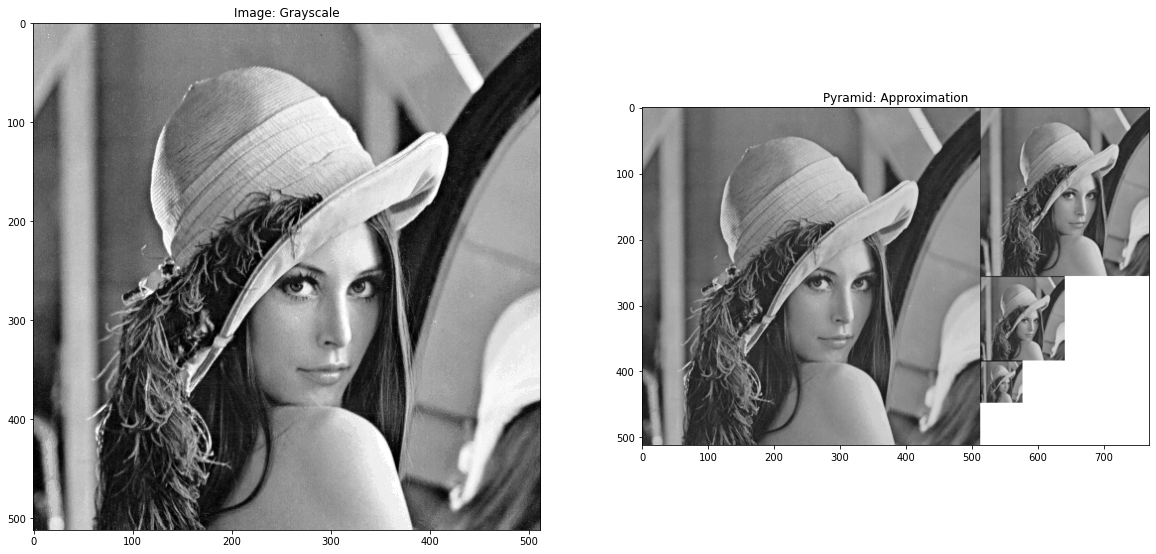

In [52]:
approximation_pyramid, approximation_levels = get_approximation_pyramid(img, 3)

fig, plot = plt.subplots(1, 2, figsize = (20, 10))

plot[0].imshow(img, cmap='gray')
plot[0].set_title("Image: Grayscale")

plot[1].imshow(approximation_pyramid, cmap='gray')
plot[1].set_title("Pyramid: Approximation")

In [58]:
def get_prediction_residual_pyramid(approximation_levels, steps):
  prediction_residual_levels = [approximation_levels[-1]]

  for step in range(steps - 1, -1, -1):
    approximation_expanded = upsample(approximation_levels[step + 1])

    prediction_residual = approximation_levels[step] - approximation_expanded
    prediction_residual = prediction_residual * 255.0 // np.max(prediction_residual)
    prediction_residual_levels.append(prediction_residual)

  R, C = prediction_residual_levels[steps].shape
  prediction_residual_pyramid = np.full((R, ((3 * C) // 2) + 1), 255)
  prediction_residual_pyramid[0:R, 0:C] = prediction_residual_levels[steps]
  previouse_row = 0

  for step in range(steps - 1, -1, -1):
    current_level = prediction_residual_levels[step]

    current_row, current_col = current_level.shape[0:2]
    prediction_residual_pyramid[previouse_row:previouse_row + current_row, C:C + current_col] = current_level

    previouse_row += current_row

  return prediction_residual_pyramid

Text(0.5, 1.0, 'Pyramid: Prediction Residual')

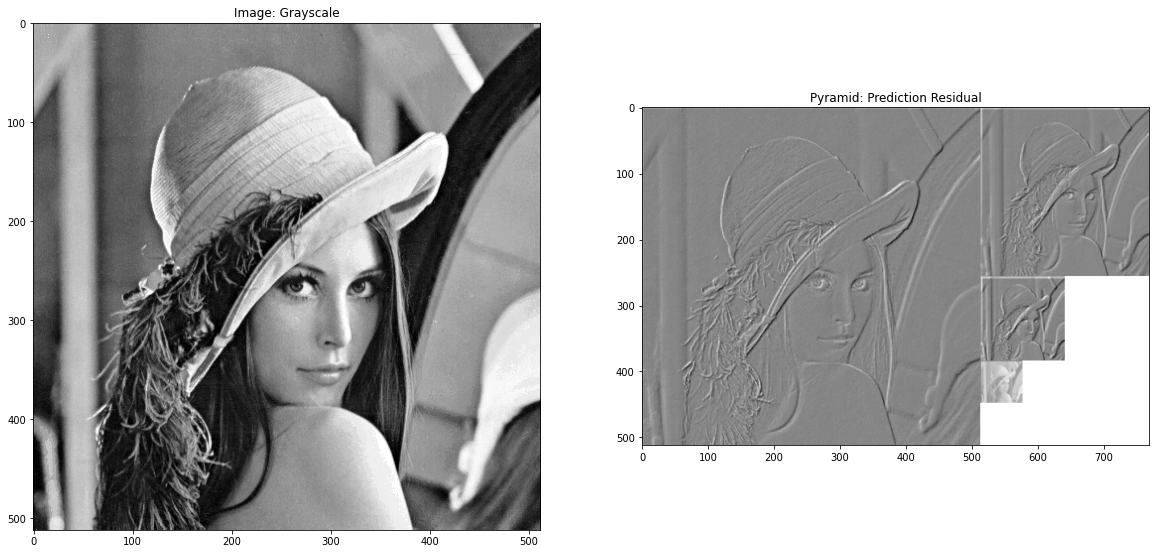

In [59]:
prediction_residual_pyramid = get_prediction_residual_pyramid(approximation_levels, 3)

fig, plot = plt.subplots(1, 2, figsize = (20, 10))

plot[0].imshow(img, cmap='gray')
plot[0].set_title("Image: Grayscale")

plot[1].imshow(prediction_residual_pyramid, cmap='gray')
plot[1].set_title("Pyramid: Prediction Residual")